# 航空公司客户价值分析

# 挖掘目标

- 借助航空公司客户数据，，对客户进行分类
- 对不同客户类别进行特征分析，比较不同类客户的客户价值
- 对不同价值的客户类别提供个性化服务，制定相应的营销策略

## 分析方法和过程

识别客户价值应用最广泛的模型是通过三个指标（最近消费间隔（Recency），消费频率（Frequency）和消费金额（Monetary））来进行客户细分，识别出高价值的客户，简称RFM模型。

而在航空公司的情况中，由于航班票价收到距离、舱位等等多个条件的影响，只是消费金额并不能表示客户对于航空公司的价值，我们使用客户在一段时间内累积的飞行里程M和客户在一定时间内乘坐仓位所对应的折扣系数C替代消费金额，李伟考虑到航空公司会员入会时间的长短在一定程度上能够影响客户价值，所以在模型中增加客户关系长度L。

最终，我们采用：
- 客户关系长度L
- 最近消费时间间隔R
- 消费频率F
- 飞行里程M
- 折扣系数C
五个指标来作为航空公司识别客户的价值指标，使用K-Means进行聚类分析，找到有价值的客户，记为LRFMC模型。

航空客运信息挖掘主要包括以下步骤：
- 从航空公司的数据源中进行选择性抽取与新增数据抽取分别形成历史数据和增量数据
- 对步骤1中形成的两个数据集进行数据探索分析与预处理，包括数据缺失值与异常值的探索分析，数据的属性规约、清洗和变换
- 利用步骤2形成的数据建模进行客户分群，对各个客户群进行特征分析，识别出有价值的客户
- 针对模型结果得到不同价值的客户，采用不同的营销手段，提供定制化的服务

### 数据抽取

从航空公司系统内的客户基本信息、乘机信息以及积分信息等详细数据中，根据末次飞行日期，抽取2012-04-01到2014-03-31内所有乘客的详细数据，总共62988条记录，包含会员卡号、性别、飞行次数等44个属性。

### 数据探索分析

In [1]:
# 对数据进行基本的探索
# 查找每列属性中的空值个数、最大值、最小值信息

import pandas as pd

datafile = './data/data_7/air_data.csv'
resultfile = './data/data_7/explore.xls'

data = pd.read_csv(datafile)
explore = data.describe(include='all').T[['count', 'max', 'min']]

explore['count'] = len(data) - explore['count']
explore.columns = ['空值记录数', '最大值', '最小值']

explore.to_excel(resultfile)

In [2]:
explore.loc[['SUM_YR_1', 'SUM_YR_2', 'avg_discount', 'SEG_KM_SUM']]

,空值记录数,最大值,最小值
SUM_YR_1,551,239560,0
SUM_YR_2,138,234188,0
avg_discount,0,1.5,0
SEG_KM_SUM,0,580717,368


经过探索我们发现，在票价、平均折扣率和总飞信公里数中，都出现了0值，对于任何一个有飞行记录的客户来讲，这都是不合理，可能是由于记录错误导致。

除非该客户在这段时间内没有乘坐过任何航班，那么上述属性同时为零，这是合理的情况。

### 数据预处理

**数据清洗**

过滤所有不符合常理的数据，首先要去除所有票价为空值的数据，此外，符合常理的数据包括以下几种情况：
- 票价不为0
- 平均折扣率和总飞行公里数同时为0

In [3]:
datafile = './data/data_7/air_data.csv'
cleanedfile = './data/data_7/data_cleaned.csv'

data = pd.read_csv(datafile)

print('原始数据集大小：{}'.format(data.shape[0]))
data = data[(data['SUM_YR_1'].notnull()) & (data['SUM_YR_2'].notnull())]
print('去除票价为空值后数据集大小：{}'.format(data.shape[0]))
cond1 = data['SUM_YR_1'] != 0
cond2 = data['SUM_YR_2'] != 0
cond3 = (data.avg_discount == 0) & (data.SEG_KM_SUM == 0)
cond = cond1 | cond2 | cond3
data = data[cond]
print('去除不合理数据后数据集大小：{}'.format(data.shape[0]))
data.to_csv(cleanedfile)

原始数据集大小：62988
去除票价为空值后数据集大小：62299
去除不合理数据后数据集大小：62044


**属性规约**

选择与LRFMC指标相关的6个属性：
- FFP_DATE
- LOAD_TIME
- FLIGHT_COUNT
- avg_discount
- SEG_KM_SUM
- LAST_TO_END

In [4]:
data = data[['FFP_DATE', 'LOAD_TIME', 'FLIGHT_COUNT', 'avg_discount', 'SEG_KM_SUM', 'LAST_TO_END']]
data.columns = [_.lower() for _ in data.columns]
data.head()

,ffp_date,load_time,flight_count,avg_discount,seg_km_sum,last_to_end
0,2006/11/02,2014/03/31,210,0.961639,580717,1
1,2007/02/19,2014/03/31,140,1.252314,293678,7
2,2007/02/01,2014/03/31,135,1.254676,283712,11
3,2008/08/22,2014/03/31,23,1.090870,281336,97
4,2009/04/10,2014/03/31,152,0.970658,309928,5


In [5]:
data.shape

(62044, 6)

**数据变换**

本案例中主要采用的数据变换形式是属性构造和数据标准化。

- l = load_time - ffp_date
- r = last_to_end
- f = flight_count
- m = seg_km_Sum
- c = avg_discount

In [6]:
datafile = './data/data_7/zscoredata.xls'
zscoredfile = './data/data_7/zscoreddata.xls'

data = pd.read_excel(datafile)
data = (data - data.mean()) / data.std()

data.columns = ['Z'+_ for _ in data.columns]

data.to_excel(zscoredfile)

In [7]:
data.head()

,ZL,ZR,ZF,ZM,ZC
0,1.689882,0.140299,-0.635788,0.068794,-0.337186
1,1.689882,-0.322442,0.852453,0.843848,-0.553613
2,1.681743,-0.487707,-0.210576,0.158569,-1.094680
3,1.534185,-0.785184,0.002030,0.273091,-1.148787
4,0.890167,-0.426559,-0.635788,-0.685170,1.231909


### 模型构建

**客户聚类**

采用KMEANS聚类算法，将客户分成5类（需要结合对业务的理解分析来确定类别数量）

In [8]:
from sklearn.cluster import KMeans

k = 5

kmodel = KMeans(n_clusters=k, n_jobs=4).fit(data)
print('聚类中心：\n{}'.format(kmodel.cluster_centers_))
print('各样本对应的类别：\n{}'.format(kmodel.labels_))

聚类中心：
[[-7.00589165e-01 -4.15214914e-01 -1.60729692e-01 -1.60504902e-01
  -2.56584147e-01]
 [ 4.83476474e-01 -7.99417769e-01  2.48236495e+00  2.42356419e+00
   3.09430418e-01]
 [ 5.13196772e-02 -2.47695842e-03 -2.31029238e-01 -2.35226271e-01
   2.17701890e+00]
 [-3.14083365e-01  1.68668163e+00 -5.73851609e-01 -5.36605129e-01
  -1.72552329e-01]
 [ 1.16068233e+00 -3.77321624e-01 -8.70112346e-02 -9.49539141e-02
  -1.58617232e-01]]
各样本对应的类别：
[4 4 4 ... 4 4 4]


In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

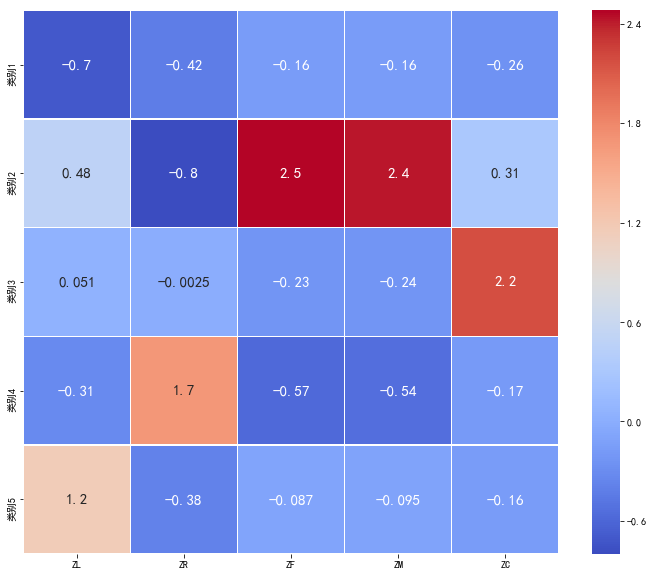

In [17]:
plt.figure(figsize=(12, 10))
sns.heatmap(kmodel.cluster_centers_, cmap='coolwarm', linewidths=0.2,
            annot=True, annot_kws={'size': 15},
            xticklabels=['ZL', 'ZR', 'ZF', 'ZM', 'ZC'],
            yticklabels=['类别1', '类别2', '类别3', '类别4', '类别5'])

In [11]:
data['class'] = kmodel.labels_

In [15]:
class_count = data['class'].value_counts().reset_index()
class_count['index'] = class_count['index'].map(dict(zip(list(range(5)), ['类别'+str(i+1) for i in range(5)])))
class_count.columns = ['class', 'number']
class_count = class_count.sort_values('class', ascending=True)
class_count

,class,number
0,类别1,24626
3,类别2,5340
4,类别3,4232
2,类别4,12120
1,类别5,15726


**聚类结果**

- 类别1:一般与低价值客户
- 类别2：重要保持客户，高F，高M， 低R，是最理想的客户类型，然而数量较少，需要加强这种客户的发展
- 类别3：重要发展客户，高C，低L， 低F， 低M，需要加强这类客户的满意度，使他们逐渐成为公司的忠诚用户
- 类别4：一般与低价值客户
- 类别5：重要挽留客户，高L，低R，过去可能是比较优质的客户，但已经有一段时间没有乘坐过本公司航班，需要重点联系，延长客户的生命周期